# 0-Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay, balanced_accuracy_score
#from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, QuantileTransformer, PowerTransformer
import tensorflow as tf
from tensorflow import keras
from keras import regularizers
from keras.optimizers import Adam
#from keras.backend import expand_dims
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential
from keras.constraints import MaxNorm
from keras.layers import Activation, Dense, Conv1D, Flatten, MaxPooling1D, Dropout, BatchNormalization, SpatialDropout1D

In [4]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

# 1- Load Data

In [5]:
s_aureus = pd.read_csv('s_aureus_driams_a_bin3_2000_20000Da.csv')
s_aureus.head()

,2000,2003,2006,2009,2012,2015,2018,2021,2024,2027,...,19991,19994,19997,code,species,Oxacillin,Clindamycin,Ceftriaxone,Ciprofloxacin,Fusidic acid
0,951.428571,826.125000,944.857143,898.428571,1007.714286,936.000000,828.571429,812.000000,782.714286,741.625000,...,35.5,20.5,27.342857,029f0abf-1664-424f-88cb-11c9c8af2b11,Staphylococcus aureus,0.0,0.0,0.0,0.0,1.0
1,784.714286,701.125000,681.571429,762.142857,737.571429,733.000000,735.857143,659.571429,802.714286,554.375000,...,30.0,40.5,34.695238,08149af1-10f5-4f02-81d8-3d46d66d4a7a,Staphylococcus aureus,0.0,0.0,0.0,0.0,0.0
2,50.875000,89.142857,56.142857,151.285714,132.714286,110.428571,47.285714,63.428571,100.375000,52.142857,...,2.5,30.5,11.288462,08fe3876-ecee-4ddc-9aa9-a84f605757f7,Staphylococcus aureus,0.0,0.0,0.0,0.0,0.0
3,843.285714,816.500000,734.428571,1027.142857,979.428571,875.571429,912.142857,714.428571,945.428571,886.500000,...,15.5,8.0,20.057143,0a9fdd4b-7180-47c0-849e-cb32d46da94c,Staphylococcus aureus,0.0,0.0,0.0,0.0,0.0
4,307.857143,295.000000,246.714286,181.571429,258.000000,318.714286,295.714286,300.857143,278.142857,256.125000,...,25.5,32.0,24.990476,0d82f4c4-473c-49d8-8c85-e3e36e96d047,Staphylococcus aureus,1.0,0.0,1.0,1.0,0.0


# Preprocessing Data

In [6]:
s_aureus_oxacillin = s_aureus.drop(columns=['code','species', 'Clindamycin', 'Ceftriaxone', 'Ciprofloxacin', 'Fusidic acid'])
s_aureus_oxacillin.dropna(axis=0, how="any", inplace=True)

In [7]:
s_aureus_ceftriaxone = s_aureus.drop(columns=['Oxacillin', 'Clindamycin', 'Ceftriaxone', 'Fusidic acid'])
#ceftriaxone.dropna(axis=0, how="any", inplace=True)
s_aureus_ceftriaxone.dropna(axis=0, how="any", inplace=True)
s_aureus_ceftriaxone.shape

(3757, 6003)

In [8]:
s_aureus_oxacillin.head()

,2000,2003,2006,2009,2012,2015,2018,2021,2024,2027,...,19973,19976,19979,19982,19985,19988,19991,19994,19997,Oxacillin
0,951.428571,826.125000,944.857143,898.428571,1007.714286,936.000000,828.571429,812.000000,782.714286,741.625000,...,14.333333,24.0,68.0,19.0,19.000000,50.0,35.5,20.5,27.342857,0.0
1,784.714286,701.125000,681.571429,762.142857,737.571429,733.000000,735.857143,659.571429,802.714286,554.375000,...,15.666667,39.0,19.5,42.0,69.666667,31.0,30.0,40.5,34.695238,0.0
2,50.875000,89.142857,56.142857,151.285714,132.714286,110.428571,47.285714,63.428571,100.375000,52.142857,...,20.666667,17.0,2.0,18.0,18.000000,11.5,2.5,30.5,11.288462,0.0
3,843.285714,816.500000,734.428571,1027.142857,979.428571,875.571429,912.142857,714.428571,945.428571,886.500000,...,22.333333,33.0,29.0,14.5,21.666667,24.5,15.5,8.0,20.057143,0.0
4,307.857143,295.000000,246.714286,181.571429,258.000000,318.714286,295.714286,300.857143,278.142857,256.125000,...,26.666667,25.5,18.0,53.5,23.000000,24.5,25.5,32.0,24.990476,1.0


In [152]:
s_aureus_oxacillin

,2000,2003,2006,2009,2012,2015,2018,2021,2024,2027,...,19973,19976,19979,19982,19985,19988,19991,19994,19997,Oxacillin
0,951.428571,826.125000,944.857143,898.428571,1007.714286,936.000000,828.571429,812.000000,782.714286,741.625000,...,14.333333,24.0,68.0,19.0,19.000000,50.0,35.5,20.500000,27.342857,0.0
1,784.714286,701.125000,681.571429,762.142857,737.571429,733.000000,735.857143,659.571429,802.714286,554.375000,...,15.666667,39.0,19.5,42.0,69.666667,31.0,30.0,40.500000,34.695238,0.0
2,50.875000,89.142857,56.142857,151.285714,132.714286,110.428571,47.285714,63.428571,100.375000,52.142857,...,20.666667,17.0,2.0,18.0,18.000000,11.5,2.5,30.500000,11.288462,0.0
3,843.285714,816.500000,734.428571,1027.142857,979.428571,875.571429,912.142857,714.428571,945.428571,886.500000,...,22.333333,33.0,29.0,14.5,21.666667,24.5,15.5,8.000000,20.057143,0.0
4,307.857143,295.000000,246.714286,181.571429,258.000000,318.714286,295.714286,300.857143,278.142857,256.125000,...,26.666667,25.5,18.0,53.5,23.000000,24.5,25.5,32.000000,24.990476,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3786,288.000000,330.285714,296.142857,265.142857,310.750000,287.000000,345.000000,260.000000,198.714286,257.285714,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.004038,0.0
3787,1286.142857,989.714286,938.285714,901.428571,872.000000,1001.000000,1061.571429,890.857143,813.857143,961.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.053908,0.0
3788,986.857143,977.285714,892.285714,986.714286,1045.875000,986.857143,963.571429,968.571429,960.857143,969.714286,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.039084,0.0
3789,141.857143,197.428571,148.142857,114.000000,125.857143,158.750000,176.571429,148.285714,149.714286,151.714286,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.012113,0.0


## Enfoque en clase minoritaria

In [9]:
minority_class = s_aureus_oxacillin[s_aureus_oxacillin['Oxacillin'] == 1].drop(columns=['Oxacillin'])


In [155]:
etiquetas = s_aureus_oxacillin[s_aureus_oxacillin['Oxacillin'] == 1].iloc[:, 6000].values

Diffusion model


In [10]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [11]:
torch.manual_seed(42)
np.random.seed(42)

In [12]:
# Preprocesamiento
scaler = StandardScaler()
scaled_data = scaler.fit_transform(minority_class)

In [14]:
# Modelo de Difusión
class DiffusionModel(nn.Module):
    def __init__(self, input_dim):
        super(DiffusionModel, self).__init__()
        self.model = nn.Sequential( 
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(p=0.2),  # Regularización Dropout
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(p=0.2),  # Regularización Dropout
            nn.Linear(128, input_dim)
        )


    def forward(self, x):
        return self.model(x)


In [15]:
# Función de ruido (Scheduler)
def add_noise(data, timesteps, noise_scale=1.0):
    noise = np.random.normal(0, noise_scale, data.shape) * np.sqrt(timesteps / 100)
    noisy_data = data + noise
    return noisy_data, noise


In [16]:
# Configuración del modelo
input_dim = scaled_data.shape[1]
model = DiffusionModel(input_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.SmoothL1Loss()  # O Huber Loss


In [17]:
# Scheduler de tasa de aprendizaje
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)


In [18]:
# Entrenamiento
scaled_data_tensor = torch.tensor(scaled_data, dtype=torch.float32)
epochs = 500
losses = []  # Para guardar la pérdida por época

for epoch in range(epochs):
    timesteps = np.random.randint(1, 100)
    noisy_data, noise = add_noise(scaled_data, timesteps)
    noisy_data_tensor = torch.tensor(noisy_data, dtype=torch.float32)
    noise_tensor = torch.tensor(noise, dtype=torch.float32)

    optimizer.zero_grad()
    predicted_noise = model(noisy_data_tensor)
    loss = loss_fn(predicted_noise, noise_tensor)
    loss.backward()
    optimizer.step()
    scheduler.step()  # Actualiza la tasa de aprendizaje

    losses.append(loss.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{epochs} - Loss: {loss.item()}")


Epoch 0/500 - Loss: 0.2534927725791931
Epoch 100/500 - Loss: 0.3576211929321289
Epoch 200/500 - Loss: 0.36513644456863403
Epoch 300/500 - Loss: 0.29700008034706116
Epoch 400/500 - Loss: 0.25247734785079956


In [19]:
# Generación de Datos Sintéticos
def generate_synthetic_data(model, num_samples, input_dim):
    model.eval()
    with torch.no_grad():
        synthetic_data = np.random.normal(0, 1, (num_samples, input_dim))
        for t in range(100, 0, -1):  # Reverse diffusion
            synthetic_data = synthetic_data - model(torch.tensor(synthetic_data, dtype=torch.float32)).numpy() * (t / 100)
        return synthetic_data

In [49]:
s_aureus_oxacillin[s_aureus_oxacillin['Oxacillin'] == 0].shape[0]-s_aureus_oxacillin[s_aureus_oxacillin['Oxacillin'] == 1].shape[0]

2338

In [23]:

synthetic_data = generate_synthetic_data(model, s_aureus_oxacillin[s_aureus_oxacillin['Oxacillin'] == 0].shape[0]-s_aureus_oxacillin[s_aureus_oxacillin['Oxacillin'] == 1].shape[0], input_dim)
synthetic_data_rescaled = scaler.inverse_transform(synthetic_data)


In [29]:
synthetic_data.shape

(2338, 6000)

In [50]:

# Cambiar el tipo de datos a float32
synthetic_samples_numpy = synthetic_data_rescaled.astype(np.float32)

# Mostrar las muestras generadas
synthetic_samples_numpy.shape

(2338, 6000)

In [31]:
nombres_columnas = minority_class.columns


In [32]:
nombres_columnas

Index(['2000', '2003', '2006', '2009', '2012', '2015', '2018', '2021', '2024',
       '2027',
       ...
       '19970', '19973', '19976', '19979', '19982', '19985', '19988', '19991',
       '19994', '19997'],
      dtype='object', length=6000)

In [51]:
synthetic_data_df = pd.DataFrame(synthetic_samples_numpy, columns=nombres_columnas)


In [52]:
synthetic_data_df

,2000,2003,2006,2009,2012,2015,2018,2021,2024,2027,...,19970,19973,19976,19979,19982,19985,19988,19991,19994,19997
0,-1536.418701,1262.406738,7793.511230,2594.559570,2890.494385,5197.008301,1217.154785,110.461906,-3946.723877,4176.337402,...,28.084932,0.001924,-11.867554,71.878769,61.194813,55.905663,25.967516,-70.037117,7.976947,-27.010073
1,856.003723,709.121155,2744.817871,1183.757935,233.112640,2298.138916,1103.626099,-4284.961426,-3821.604492,136.576355,...,-18.681761,-17.108820,0.453956,55.250042,49.634350,20.365988,-0.374411,20.380623,-19.596901,30.785950
2,3091.854980,595.492737,13.547603,1683.853027,2288.239746,2552.552490,1628.763550,4770.423828,586.252075,4952.724121,...,65.103371,-30.288280,24.166821,7.804317,-12.030019,51.126560,8.991321,32.061970,-31.332466,42.606884
3,-912.333496,3237.871338,98.694878,4110.980469,-4753.744141,178.257767,-4186.497070,1897.932861,2393.378174,3470.227051,...,10.958302,-3.986525,-3.289316,-34.637039,21.479078,28.094643,12.358366,23.618254,27.064226,-5.515669
4,1066.069946,2398.134277,1483.848755,604.988098,-1958.349121,-522.710754,4349.446777,1753.820190,-132.667877,2520.413818,...,42.250080,14.787484,20.836058,29.602842,34.124691,-36.054771,7.684555,41.732220,-0.680483,50.578373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2333,-1993.413330,-1384.830933,4335.345703,3875.011963,2116.184326,-2702.382568,-619.341248,-147.906036,3263.703125,452.457581,...,58.468349,51.980789,47.454235,14.709167,-17.265867,10.661356,29.963074,76.815628,43.142223,51.113602
2334,5796.602539,4520.106934,3444.978760,165.286880,-5676.267578,2280.808105,3773.047607,3030.748779,2162.536865,2173.433350,...,58.756138,-10.140686,78.140526,8.136166,6.823637,-3.270366,40.383728,88.920143,15.204962,17.702734
2335,2251.962402,185.352432,790.651855,-5564.102051,-2304.696289,-1054.132935,1704.493896,327.862701,-1534.444946,-2095.652832,...,21.776247,33.870655,31.489424,18.676027,7.752984,-5.797621,43.106129,1.234750,15.894290,42.568020
2336,-2765.651123,3081.537354,884.506592,4533.094238,1831.534180,1188.295776,-2345.116943,115.002396,-1867.256470,334.738312,...,-18.624929,21.651314,53.676105,102.058609,23.686388,15.617203,17.511900,-45.995697,-8.386205,27.289055


In [53]:
combined_data = pd.concat([synthetic_data_df, s_aureus_oxacillin], ignore_index=True)


In [54]:
combined_data = combined_data.fillna(1)

In [55]:
combined_data

,2000,2003,2006,2009,2012,2015,2018,2021,2024,2027,...,19973,19976,19979,19982,19985,19988,19991,19994,19997,Oxacillin
0,-1536.418701,1262.406738,7793.511230,2594.559570,2890.494385,5197.008301,1217.154785,110.461906,-3946.723877,4176.337402,...,0.001924,-11.867554,71.878769,61.194813,55.905663,25.967516,-70.037117,7.976947,-27.010073,1.0
1,856.003723,709.121155,2744.817871,1183.757935,233.112640,2298.138916,1103.626099,-4284.961426,-3821.604492,136.576355,...,-17.108820,0.453956,55.250042,49.634350,20.365988,-0.374411,20.380623,-19.596901,30.785950,1.0
2,3091.854980,595.492737,13.547603,1683.853027,2288.239746,2552.552490,1628.763550,4770.423828,586.252075,4952.724121,...,-30.288280,24.166821,7.804317,-12.030019,51.126560,8.991321,32.061970,-31.332466,42.606884,1.0
3,-912.333496,3237.871338,98.694878,4110.980469,-4753.744141,178.257767,-4186.497070,1897.932861,2393.378174,3470.227051,...,-3.986525,-3.289316,-34.637039,21.479078,28.094643,12.358366,23.618254,27.064226,-5.515669,1.0
4,1066.069946,2398.134277,1483.848755,604.988098,-1958.349121,-522.710754,4349.446777,1753.820190,-132.667877,2520.413818,...,14.787484,20.836058,29.602842,34.124691,-36.054771,7.684555,41.732220,-0.680483,50.578373,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6123,288.000000,330.285714,296.142857,265.142857,310.750000,287.000000,345.000000,260.000000,198.714286,257.285714,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004038,0.0
6124,1286.142857,989.714286,938.285714,901.428571,872.000000,1001.000000,1061.571429,890.857143,813.857143,961.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.053908,0.0
6125,986.857143,977.285714,892.285714,986.714286,1045.875000,986.857143,963.571429,968.571429,960.857143,969.714286,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.039084,0.0
6126,141.857143,197.428571,148.142857,114.000000,125.857143,158.750000,176.571429,148.285714,149.714286,151.714286,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012113,0.0


In [56]:
X = combined_data.iloc[:, 0:6000].values  # variables independientes (espectros de masa)
y = combined_data.iloc[:, 6000].values    # variable dependientes (resistencia a ciprofloxacin)
X = np.asarray(X).astype(np.float32)
y = np.asarray(y).astype(np.float32)


In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify=y)

## Termino oversampling

In [58]:
len(X)

6128

In [59]:
len(X_train)

4902

In [60]:
len(y_train)

4902

In [61]:
scaler=Normalizer(norm='max')
sc_X = scaler
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [62]:
sample_size = X_train.shape[0] # numero de muestras en el set de datos
time_steps  = X_train.shape[1] # numero de atributos en el set de datos
input_dimension = 1            #

X_train_reshaped = X_train.reshape(sample_size,time_steps,input_dimension)
X_test_reshaped = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [63]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.000001)
early_st = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

n_timesteps = X_train_reshaped.shape[1] #
n_features  = X_train_reshaped.shape[2] #

In [64]:
print(pd.Series(y_train).value_counts())


0.0    2451
1.0    2451
Name: count, dtype: int64


# Create and fit DeepAMR model

In [65]:
model = Sequential(name="Modelo_s_aureus_ciprofloxacin")
init_mode = 'normal'
model.add(Conv1D(filters=(64), kernel_size=(17), input_shape = (n_timesteps,n_features), name='Conv_1'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D_1"))

model.add(Conv1D(filters=(128), kernel_size=(9),kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001),  name='Conv_2'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D_2"))

model.add(Conv1D(filters=(256), kernel_size=(5),kernel_initializer=init_mode,kernel_regularizer=regularizers.l2(0.0001),   name='Conv_3'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D_3"))

model.add(Conv1D(filters=(256), kernel_size=(5),kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001),   name='Conv_4'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D_4"))

model.add(Flatten())
model.add(Dropout(0.65))
model.add(Dense(256, activation='relu',kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001), name="fully_connected_0"))
model.add(Dense(64, activation='relu',kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001), name="fully_connected_1"))
model.add(Dense(64, activation='relu',kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001),  name="fully_connected_2"))
model.add(Dense(n_features, activation='sigmoid', name="OUT_Layer"))

model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'binary_crossentropy',  metrics=METRICS)
model.summary()

Model: "Modelo_s_aureus_ciprofloxacin"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_1 (Conv1D)             (None, 5984, 64)          1152      
                                                                 
 batch_normalization_4 (Batc  (None, 5984, 64)         256       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 5984, 64)          0         
                                                                 
 MaxPooling1D_1 (MaxPooling1  (None, 2992, 64)         0         
 D)                                                              
                                                                 
 Conv_2 (Conv1D)             (None, 2984, 128)         73856     
                                                                 
 batch_normalization_5 (Batc  (None, 

In [66]:
history = model.fit(X_train_reshaped, y_train, epochs=100, batch_size=10, verbose=1, validation_split=0.1, callbacks=[reduce_lr,early_st])

Epoch 1/100


2024-12-25 12:30:10.858567: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8907
2024-12-25 12:30:10.884944: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-12-25 12:30:11.797800: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


442/442 [==============================] - 16s 29ms/step - loss: 5.8562 - tp: 1717.0000 - fp: 134.0000 - tn: 2078.0000 - fn: 482.0000 - accuracy: 0.8603 - precision: 0.9276 - recall: 0.7808 - auc: 0.8991 - prc: 0.9310 - val_loss: 5.6430 - val_tp: 40.0000 - val_fp: 0.0000e+00 - val_tn: 239.0000 - val_fn: 212.0000 - val_accuracy: 0.5682 - val_precision: 1.0000 - val_recall: 0.1587 - val_auc: 0.8824 - val_prc: 0.9040 - lr: 1.0000e-04
Epoch 2/100
442/442 [==============================] - 12s 28ms/step - loss: 4.9506 - tp: 1735.0000 - fp: 71.0000 - tn: 2141.0000 - fn: 464.0000 - accuracy: 0.8787 - precision: 0.9607 - recall: 0.7890 - auc: 0.9207 - prc: 0.9443 - val_loss: 4.6377 - val_tp: 186.0000 - val_fp: 0.0000e+00 - val_tn: 239.0000 - val_fn: 66.0000 - val_accuracy: 0.8656 - val_precision: 1.0000 - val_recall: 0.7381 - val_auc: 0.9371 - val_prc: 0.9568 - lr: 1.0000e-04
Epoch 3/100
442/442 [==============================] - 12s 28ms/step - loss: 4.3688 - tp: 1774.0000 - fp: 72.0000 - tn:

# Evaluate the model

In [67]:
y_pred  = model.predict(X_test_reshaped)
y_pred = (y_pred>0.5)
cm = confusion_matrix(y_test, y_pred)
print(cm)

39/39 [==============================] - 1s 9ms/step
[[601  12]
 [ 54 559]]


In [68]:
print("balanced acuracy:", balanced_accuracy_score(y_test, y_pred))

balanced acuracy: 0.9461663947797716


In [69]:
target_names=["0","1"]
print(classification_report(y_test, y_pred, target_names=target_names))

train_predictions_baseline = model.predict(X_train_reshaped, batch_size=10)
test_predictions_baseline = model.predict(X_test_reshaped, batch_size=10)

baseline_results = model.evaluate(X_test_reshaped, y_test, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       613
           1       0.98      0.91      0.94       613

    accuracy                           0.95      1226
   macro avg       0.95      0.95      0.95      1226
weighted avg       0.95      0.95      0.95      1226

123/123 [==============================] - 1s 6ms/step
loss :  0.378679096698761
tp :  559.0
fp :  12.0
tn :  601.0
fn :  54.0
accuracy :  0.9461663961410522
precision :  0.9789842367172241
recall :  0.9119086265563965
auc :  0.9876573085784912
prc :  0.9898900985717773



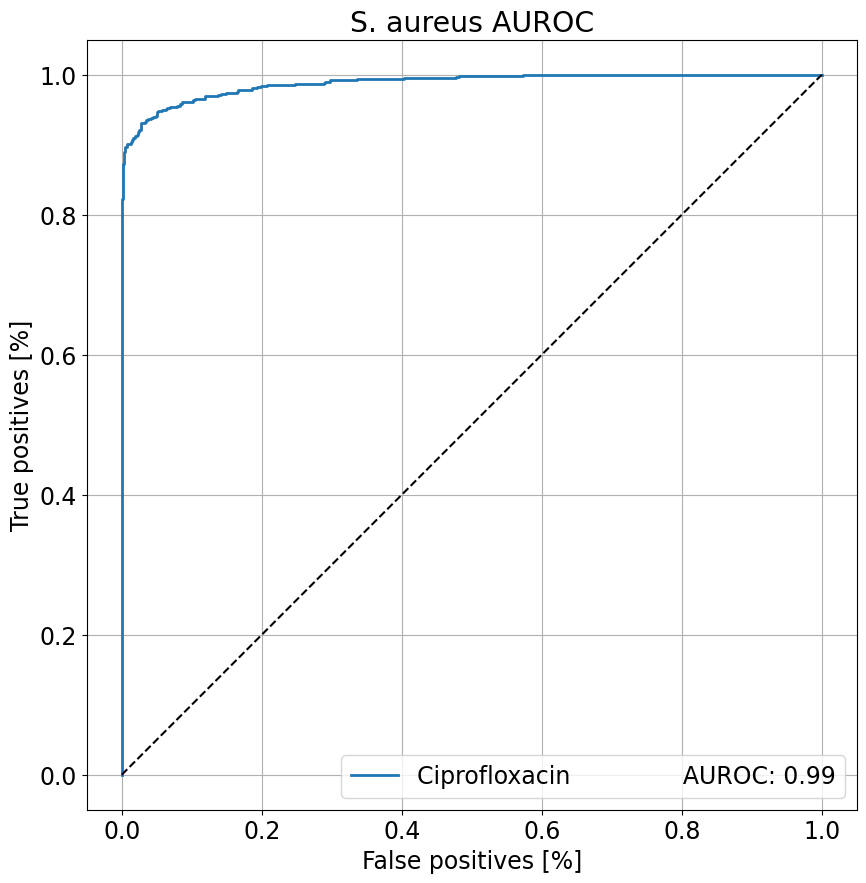

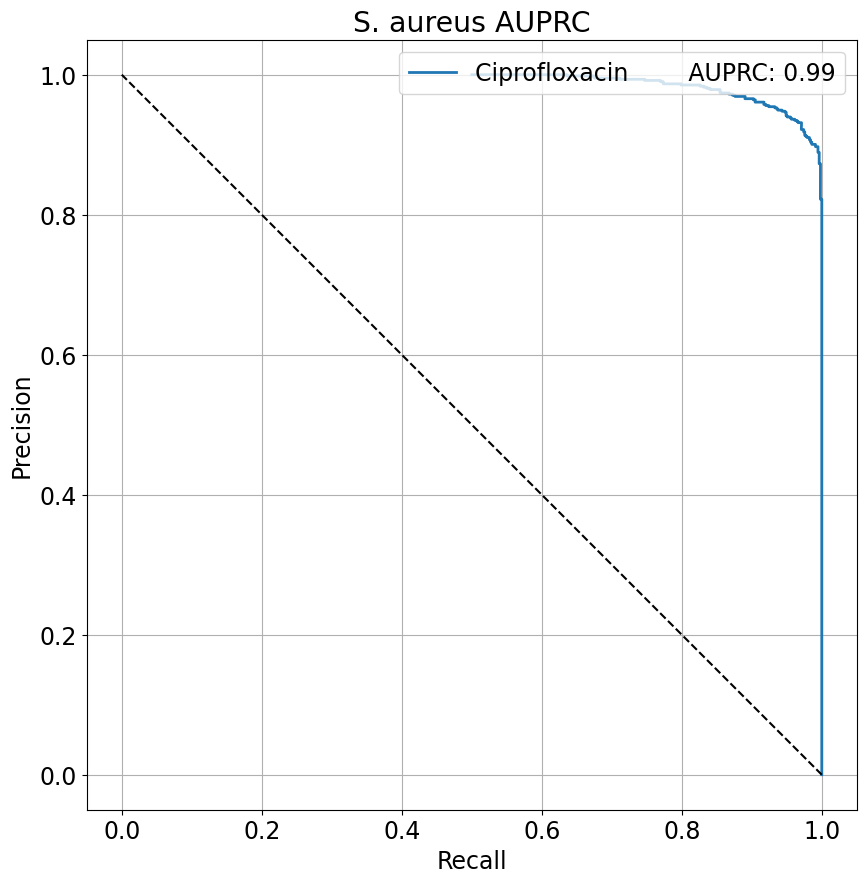

In [70]:
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams.update({'font.size': 17})
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(fp, tp, label=name, linewidth=2, **kwargs)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.title('E. coli CNN')
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.title('S. aureus AUROC')

  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')
plot_roc("Ciprofloxacin               AUROC: %0.2f" % baseline_results[8], y_test, test_predictions_baseline, color=colors[0])

plt.legend(loc='lower right')
plt.savefig('s_aureus_auroc.png', bbox_inches='tight')
plt.show()

def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.title('S. aureus AUPRC')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.plot([1, 0], [0, 1], 'k--')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

plot_prc("Ciprofloxacin        AUPRC: %0.2f" % baseline_results[9], y_test, test_predictions_baseline, color=colors[0])

plt.legend(loc='upper right')
plt.savefig('s_aureus_auprc.png', bbox_inches='tight')
plt.show()